## Importing Necessary Modules

In [2]:
import os
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

## Dataset Preparation: Linking Images with OCR Texts

In [3]:
image_dir = Path('/home/ith/Downloads/SDS/image_classification/data/images') 
ocr_dir = Path('/home/ith/Downloads/SDS/image_classification/data/ocr') 

data = []

for class_name in os.listdir(image_dir):  # loop through each class folder
    img_folder = image_dir / class_name
    ocr_folder = ocr_dir / class_name

    for file_name in os.listdir(img_folder):  # lopp through each image and text in the class folder
        if file_name.endswith('.TIF'):
            img_path = img_folder / file_name
            ocr_path = ocr_folder / f"{file_name}.txt"

            if ocr_path.exists():
                data.append({
                    'image_path': str(img_path),
                    'ocr_path': str(ocr_path),
                    'label': class_name
                })

In [4]:
data

[{'image_path': '/home/ith/Downloads/SDS/image_classification/data/images/6/5f321f4b-a47f-42da-8193-2784f1de59bd.TIF',
  'ocr_path': '/home/ith/Downloads/SDS/image_classification/data/ocr/6/5f321f4b-a47f-42da-8193-2784f1de59bd.TIF.txt',
  'label': '6'},
 {'image_path': '/home/ith/Downloads/SDS/image_classification/data/images/6/4bba6730-75b4-4b3a-a99f-1c8116c604fe.TIF',
  'ocr_path': '/home/ith/Downloads/SDS/image_classification/data/ocr/6/4bba6730-75b4-4b3a-a99f-1c8116c604fe.TIF.txt',
  'label': '6'},
 {'image_path': '/home/ith/Downloads/SDS/image_classification/data/images/6/9ef64d70-1bc8-4c97-8c83-7efaaf8170ce.TIF',
  'ocr_path': '/home/ith/Downloads/SDS/image_classification/data/ocr/6/9ef64d70-1bc8-4c97-8c83-7efaaf8170ce.TIF.txt',
  'label': '6'},
 {'image_path': '/home/ith/Downloads/SDS/image_classification/data/images/6/76d75408-7aa7-4d2d-a11e-e9ce4073e7dc.TIF',
  'ocr_path': '/home/ith/Downloads/SDS/image_classification/data/ocr/6/76d75408-7aa7-4d2d-a11e-e9ce4073e7dc.TIF.txt',
 

In [4]:
# converting the string labels into numeric form because PyTorch expect numerical class labels, not strings.
labels = [d['label'] for d in data]
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

for i, d in enumerate(data):
    d['encoded_label'] = encoded_labels[i]

In [5]:
d

{'image_path': '/home/ith/Downloads/SDS/image_classification/data/images/9/972d9590-d328-4111-b9d1-87570ba3ab8b.TIF',
 'ocr_path': '/home/ith/Downloads/SDS/image_classification/data/ocr/9/972d9590-d328-4111-b9d1-87570ba3ab8b.TIF.txt',
 'label': '9',
 'encoded_label': np.int64(4)}

### Splitting the Dataset

In [7]:
train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=42,stratify=encoded_labels) #used stratify to ensure that the split maintains the same proportion of classes in both sets

train_val_labels = [d['encoded_label'] for d in train_val_data]   # we can't use encoded_labels her because it contain labels for whole data and its length doesn't match the subset
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42,stratify=train_val_labels)

In [8]:
len(train_data),len(val_data),len(test_data)

(1800, 450, 250)

## Classification using only image features

#### Image Embedding using ResNet-50

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove classifier only to keep the feature extractor part 
resnet.to(device)
resnet.eval()

# image pre-processing according to the ResNet model's requirements
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  #normalizes the pixel values of the image so they match what the ResNet model expects
])

def get_image_embedding(img_path):
    image = Image.open(img_path).convert('RGB')
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():   
        emb = resnet(tensor).squeeze().cpu().numpy()
    return emb  # shape: (2048,)


/home/ith/Downloads/SDS/image_classification/SDS/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/ith/Downloads/SDS/image_classification/SDS/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ith/Downloads/SDS/image_classification/SDS/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNe

In [10]:
# Test the embedding function
sample_img_path = '/home/ith/Downloads/SDS/image_classification/data/images/6/9ef64d70-1bc8-4c97-8c83-7efaaf8170ce.TIF'
embedding = get_image_embedding(sample_img_path)

print("Embedding shape:", embedding.shape)
print("First 5 values:", embedding[:5])


Embedding shape: (2048,)
First 5 values: [0.00122215 0.00347373 0.06951286 0.02893616 0.37235728]


### Image Classifier Neural Network

In [11]:
class ImageClassifier(nn.Module):
    #Takes the 2048-dim image embedding and maps it to a 256-dim hidden representation
    def __init__(self, input_dim=2048, hidden_dim=256, num_classes=5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  
        x = self.dropout(x)
        return self.fc2(x)

#### Preparing the Validation Set for Training and Evaluation

In [12]:
image_features = [get_image_embedding(d['image_path']) for d in train_data]  # extract features for all images in the training set
X_img_tensor = torch.tensor(image_features, dtype=torch.float32)

train_labels = [d['encoded_label'] for d in train_data] # extract labels for all images in the training set
y_img_tensor = torch.tensor(train_labels, dtype=torch.long)

img_dataset = TensorDataset(X_img_tensor, y_img_tensor)  # combine features and labels into a dataset
img_loader = DataLoader(img_dataset, batch_size=32, shuffle=True) # create a DataLoader for batching

/tmp/ipykernel_306925/3549425555.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X_img_tensor = torch.tensor(image_features, dtype=torch.float32)


In [13]:
val_image_features = [get_image_embedding(d['image_path']) for d in val_data]
X_val_img_tensor = torch.tensor(val_image_features, dtype=torch.float32)

val_labels = [d['encoded_label'] for d in val_data]
y_val_img_tensor = torch.tensor(val_labels, dtype=torch.long)

val_dataset = TensorDataset(X_val_img_tensor, y_val_img_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)

In [31]:
Imagemodel = ImageClassifier()
Imagemodel.to(device)
optimizer = torch.optim.Adam(Imagemodel.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True) #Reduces the learning rate if validation loss stops improving.
criterion = nn.CrossEntropyLoss()
# Early stopping setup
patience = 5
best_loss = float('inf')
wait = 0

In [32]:
img_train_losses = []
img_eval_losses =[]

for epoch in range(100):
    # Set the model to training mode
    Imagemodel.train()
    total_train_loss = 0
    # Iterate through each batch in the training data loader
    for xb, yb in img_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = Imagemodel(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(img_loader) 
    img_train_losses.append(avg_train_loss)

    # Set the model to evaluation mode 
    Imagemodel.eval()
    total_eval_loss = 0
    # Iterate through the validation data loader
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = Imagemodel(xb)
            loss = criterion(preds, yb)
            total_eval_loss += loss.item()
    avg_eval_loss = total_eval_loss / len(val_loader)  
    img_eval_losses.append(avg_eval_loss)

    print(f"Epoch {epoch+1}, train Loss: {avg_train_loss:.4f}, val Loss: {avg_eval_loss:.4f}")

    # Early stopping: Save the best model and check if validation loss improves

    if avg_eval_loss < best_loss:
        best_loss = avg_eval_loss  # update the new best loss
        wait = 0
    else:
        wait += 1  #if validation doesnot improve, increase the wait counter 
        if wait >= patience:  # if wait reaches the number of patience epochs, it means the model hasn’t improved for that many number of epochs.
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Step scheduler
    scheduler.step(avg_eval_loss)

Epoch 1, train Loss: 0.9371, val Loss: 0.7411
Epoch 2, train Loss: 0.6708, val Loss: 0.6629
Epoch 3, train Loss: 0.5948, val Loss: 0.6177
Epoch 4, train Loss: 0.5276, val Loss: 0.5923
Epoch 5, train Loss: 0.4904, val Loss: 0.5621
Epoch 6, train Loss: 0.4333, val Loss: 0.5825
Epoch 7, train Loss: 0.4180, val Loss: 0.5561
Epoch 8, train Loss: 0.3968, val Loss: 0.5377
Epoch 9, train Loss: 0.3649, val Loss: 0.5035
Epoch 10, train Loss: 0.3408, val Loss: 0.4894
Epoch 11, train Loss: 0.3313, val Loss: 0.4866
Epoch 12, train Loss: 0.3114, val Loss: 0.4951
Epoch 13, train Loss: 0.2954, val Loss: 0.4851
Epoch 14, train Loss: 0.2677, val Loss: 0.4624
Epoch 15, train Loss: 0.2732, val Loss: 0.4639
Epoch 16, train Loss: 0.2451, val Loss: 0.4630
Epoch 17, train Loss: 0.2494, val Loss: 0.4980
Epoch 18, train Loss: 0.2223, val Loss: 0.4833
Epoch 19, train Loss: 0.2143, val Loss: 0.4691
Early stopping at epoch 19


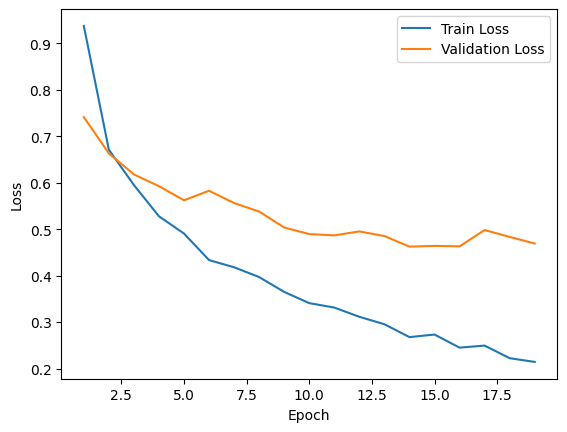

In [33]:
plt.plot(range(1,len(img_train_losses)+1), img_train_losses, label='Train Loss')
plt.plot(range(1, len(img_eval_losses)+1), img_eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Classification using only OCR Text

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class TextClassifier(nn.Module):
    def __init__(self, input_dim=1000, hidden_dim=128, num_classes=5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        return self.fc2(x)


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract text from train files
texts = []
for d in train_data:
    with open(d['ocr_path'], 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    texts.append(text)
    d['ocr_text'] = text


# Extract text from test files
val_texts = []
for d in val_data:
    with open(d['ocr_path'], 'r', encoding='utf-8', errors='ignore') as f:
        val_text = f.read()
    val_texts.append(val_text)
    d['ocr_text'] = val_text

# Fit TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)

### Data Preparation for Text Classification

In [37]:
#Convert raw text into TF-IDF vectors 
tfidf_features = vectorizer.fit_transform(texts).toarray()
X_text_tensor = torch.tensor(tfidf_features, dtype=torch.float32)

#Extract labels from the training data and convert them into a PyTorch tensor
train_labels = [d['encoded_label'] for d in train_data]
y_text_tensor = torch.tensor(train_labels, dtype=torch.long)


text_dataset = TensorDataset(X_text_tensor, y_text_tensor)
text_loader = DataLoader(text_dataset, batch_size=32, shuffle=True)

In [38]:
tfidf_val_features = vectorizer.transform(val_texts).toarray()
X_text_val_tensor = torch.tensor(tfidf_val_features, dtype=torch.float32)

val_labels = [d['encoded_label'] for d in val_data]
y_val_text_tensor = torch.tensor(val_labels, dtype=torch.long)


text_val_dataset = TensorDataset(X_text_val_tensor, y_val_text_tensor)
text_val_loader = DataLoader(text_val_dataset, batch_size=32, shuffle=True)


In [42]:
# Initialize the text classification model
Textmodel = TextClassifier()
Textmodel.to(device)
optimizer = torch.optim.Adam(Textmodel.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True) #Reduces the learning rate if validation loss stops improving.
criterion = nn.CrossEntropyLoss()
# Early stopping setup
patience = 5
best_loss = float('inf')
wait = 0

In [43]:
text_train_losses = []
text_val_losses = []

for epoch in range(100):
    Textmodel.train()
    total_train_loss = 0
    for xb, yb in text_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = Textmodel(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Store training loss for plotting
    avg_train_loss = total_train_loss / len(text_loader)
    text_train_losses.append(avg_train_loss)

    # Validation loss
    Textmodel.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in text_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = Textmodel(xb)
            loss = criterion(preds, yb)
            total_val_loss += loss.item()

    # Store validation loss for plotting
    val_loss = total_val_loss / len(text_val_loader)
    text_val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Step scheduler
    scheduler.step(val_loss)


Epoch 1, Train Loss: 1.5235, Val Loss: 1.4648
Epoch 2, Train Loss: 1.1884, Val Loss: 1.0616
Epoch 3, Train Loss: 0.9932, Val Loss: 0.9497
Epoch 4, Train Loss: 0.8731, Val Loss: 0.8372
Epoch 5, Train Loss: 0.7814, Val Loss: 0.7759
Epoch 6, Train Loss: 0.7312, Val Loss: 0.7652
Epoch 7, Train Loss: 0.6669, Val Loss: 0.6948
Epoch 8, Train Loss: 0.6219, Val Loss: 0.6837
Epoch 9, Train Loss: 0.5929, Val Loss: 0.6719
Epoch 10, Train Loss: 0.5572, Val Loss: 0.6826
Epoch 11, Train Loss: 0.5316, Val Loss: 0.6007
Epoch 12, Train Loss: 0.4813, Val Loss: 0.5856
Epoch 13, Train Loss: 0.4569, Val Loss: 0.6334
Epoch 14, Train Loss: 0.4248, Val Loss: 0.5614
Epoch 15, Train Loss: 0.4124, Val Loss: 0.5750
Epoch 16, Train Loss: 0.4046, Val Loss: 0.5501
Epoch 17, Train Loss: 0.3607, Val Loss: 0.5608
Epoch 18, Train Loss: 0.3578, Val Loss: 0.5446
Epoch 19, Train Loss: 0.3384, Val Loss: 0.5234
Epoch 20, Train Loss: 0.3259, Val Loss: 0.5609
Epoch 21, Train Loss: 0.3063, Val Loss: 0.5449
Epoch 22, Train Loss: 

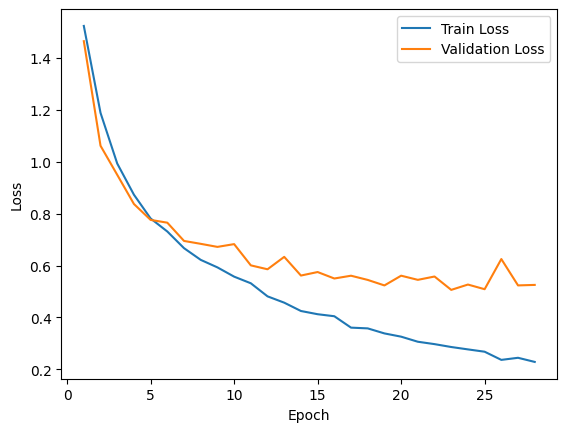

In [44]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(text_train_losses)+1), text_train_losses, label='Train Loss')
plt.plot(range(1, len(text_val_losses)+1), text_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Classification using both available data

### Combining the image and text embedding

In [45]:
X_combined = []
y_combined = []

for i, d in enumerate(train_data):
    img_feat = get_image_embedding(d['image_path'])  #get 2048-d vector from ResNet
    text_feat = tfidf_features[i]    #get 1000-d vector from TF-IDF
    combined = np.concatenate([img_feat, text_feat])  # shape: (3048,)
    X_combined.append(combined)
    y_combined.append(d['encoded_label'])

X_combined = np.array(X_combined)
y_combined = np.array(y_combined)

In [46]:
X_val_combined = []
y_val_combined = []

for i, d in enumerate(val_data):
    img_feat = get_image_embedding(d['image_path'])  #get 2048-d vector from ResNet
    text_feat = tfidf_val_features[i]    #get 1000-d vector from TF-IDF
    combined = np.concatenate([img_feat, text_feat])  # shape: (3048,)
    X_val_combined.append(combined)
    y_val_combined.append(d['encoded_label'])

X_val_combined = np.array(X_val_combined)
y_val_combined = np.array(y_val_combined)

In [47]:
class Classifier(nn.Module):
    def __init__(self, input_dim=3048, hidden_dim=512, num_classes=5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        return self.fc2(x)


#### Data Preparation for Text Classification

In [48]:
X_train_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_train_tensor = torch.tensor(y_combined, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [49]:
X_val_tensor = torch.tensor(X_val_combined, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_combined, dtype=torch.long)

val_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [50]:
# initialize the combined model
model = Classifier()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True) #Reduces the learning rate if validation loss stops improving.
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation loss
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_val_loss += loss.item()

    # Store losses for plotting
    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Step scheduler
    scheduler.step(val_losses)

Epoch 1, Train Loss: 0.8239, Val Loss: 0.5559
Epoch 2, Train Loss: 0.5418, Val Loss: 0.4091
Epoch 3, Train Loss: 0.4411, Val Loss: 0.3304
Epoch 4, Train Loss: 0.3747, Val Loss: 0.2749
Epoch 5, Train Loss: 0.3185, Val Loss: 0.2268
Epoch 6, Train Loss: 0.2696, Val Loss: 0.1950
Epoch 7, Train Loss: 0.2391, Val Loss: 0.1662
Epoch 8, Train Loss: 0.2115, Val Loss: 0.1452
Epoch 9, Train Loss: 0.1754, Val Loss: 0.1094
Epoch 10, Train Loss: 0.1737, Val Loss: 0.1051
Epoch 11, Train Loss: 0.1461, Val Loss: 0.0944
Epoch 12, Train Loss: 0.1209, Val Loss: 0.0849
Epoch 13, Train Loss: 0.0996, Val Loss: 0.0568
Epoch 14, Train Loss: 0.0909, Val Loss: 0.0583
Epoch 15, Train Loss: 0.0794, Val Loss: 0.0402
Epoch 16, Train Loss: 0.0765, Val Loss: 0.0400
Epoch 17, Train Loss: 0.0748, Val Loss: 0.0322
Epoch 18, Train Loss: 0.0694, Val Loss: 0.0359
Epoch 19, Train Loss: 0.0563, Val Loss: 0.0281
Epoch 20, Train Loss: 0.0546, Val Loss: 0.0226
Epoch 21, Train Loss: 0.0510, Val Loss: 0.0223
Epoch 22, Train Loss: 

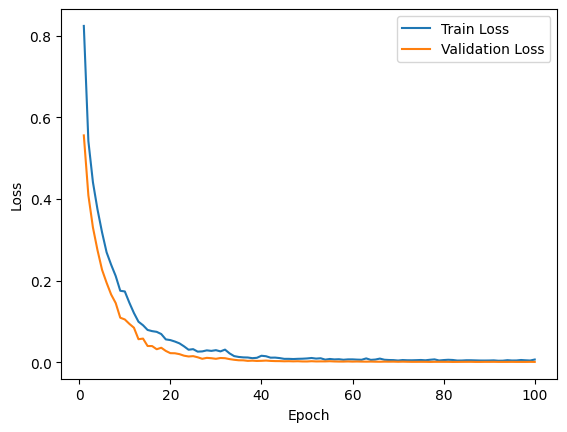

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

####  Data Preparation for the test loader for combined model

In [ ]:
test_texts = []
for d in test_data:
    with open(d['ocr_path'], 'r', encoding='utf-8', errors='ignore') as f:
        test_text = f.read()
    test_texts.append(test_text)

tfidf_features_test = vectorizer.transform(test_texts).toarray()

In [ ]:
X_test_combined = []
y_test_combined = []

for i, d in enumerate(test_data):
    img_feat = get_image_embedding(d['image_path'])  # 2048-d image vector
    text_feat = tfidf_features_test[i]               # 1000-d TF-IDF vector
    combined = np.concatenate([img_feat, text_feat]) # (3048,)
    X_test_combined.append(combined)
    y_test_combined.append(d['encoded_label'])

X_test_combined = np.array(X_test_combined)
y_test_combined = np.array(y_test_combined)

X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_combined, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Evaluate model and compute metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        predicted = torch.argmax(preds, dim=1)
        all_preds.extend(predicted)
        all_labels.extend(yb)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
Combined_f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

In [ ]:
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", Combined_f1)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))
print("Confusion Matrix:\n", conf_matrix)

Test Accuracy: 0.888
Test Precision: 0.8891655696943105
Test Recall: 0.888
Test F1 Score: 0.8871182923529575

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89        50
           1       0.96      0.92      0.94        50
           2       0.85      0.90      0.87        50
           3       0.89      0.94      0.91        50
           4       0.88      0.76      0.82        50

    accuracy                           0.89       250
   macro avg       0.89      0.89      0.89       250
weighted avg       0.89      0.89      0.89       250

Confusion Matrix:
 [[46  1  1  0  2]
 [ 3 46  0  1  0]
 [ 2  1 45  0  2]
 [ 1  0  1 47  1]
 [ 1  0  6  5 38]]


####  Data Preparation for the test loader for OCR model

In [ ]:
# Extract text from test set
test_texts = []
for d in test_data:
    with open(d['ocr_path'], 'r', encoding='utf-8', errors='ignore') as f:
        test_text = f.read()
    test_texts.append(test_text)
    d['ocr_text'] = test_text

# Transform using the already fitted TF-IDF vectorizer
tfidf_test_features = vectorizer.transform(test_texts).toarray()
X_text_test_tensor = torch.tensor(tfidf_test_features, dtype=torch.float32)

# Labels
test_labels = [d['encoded_label'] for d in test_data]
y_test_text_tensor = torch.tensor(test_labels, dtype=torch.long)

# DataLoader
text_test_dataset = TensorDataset(X_text_test_tensor, y_test_text_tensor)
text_test_loader = DataLoader(text_test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Set the model to evaluation mode
Textmodel.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in text_test_loader:
        xb = xb.to(device)
        preds = Textmodel(xb)
        predicted = torch.argmax(preds, dim=1).cpu().numpy()
        labels = yb.numpy()
        all_preds.extend(predicted)
        all_labels.extend(labels)


In [ ]:
# Accuracy
acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", acc)

# F1 Scores
OCR_f1 = f1_score(all_labels, all_preds, average='weighted')
print("Weighted F1 Score:", OCR_f1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds))


Test Accuracy: 0.82
Weighted F1 Score: 0.8228139982938745

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.95      0.78      0.86        50
           2       0.74      0.80      0.77        50
           3       0.93      0.84      0.88        50
           4       0.69      0.80      0.74        50

    accuracy                           0.82       250
   macro avg       0.83      0.82      0.82       250
weighted avg       0.83      0.82      0.82       250



####  Data Preparation for the test loader for Image model

In [ ]:
test_image_features = [get_image_embedding(d['image_path']) for d in test_data]
X_test_img_tensor = torch.tensor(test_image_features, dtype=torch.float32)

test_labels = [d['encoded_label'] for d in test_data]
y_test_img_tensor = torch.tensor(test_labels, dtype=torch.long)

Image_test_dataset = TensorDataset(X_test_img_tensor, y_test_img_tensor)
Image_test_loader = DataLoader(Image_test_dataset, batch_size=32)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

Imagemodel.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in Image_test_loader:
        xb = xb.to(device)
        preds = Imagemodel(xb)
        predicted = torch.argmax(preds, dim=1).cpu().numpy()
        labels = yb.numpy()
        all_preds.extend(predicted)
        all_labels.extend(labels)


In [ ]:
# Accuracy
acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", acc)

# F1 Scores
Image_f1 = f1_score(all_labels, all_preds, average='weighted')
print("Weighted F1 Score:", Image_f1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds))


Test Accuracy: 0.844
Weighted F1 Score: 0.8413680144019948

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.96      0.94      0.95        50
           2       0.85      0.78      0.81        50
           3       0.83      0.88      0.85        50
           4       0.82      0.66      0.73        50

    accuracy                           0.84       250
   macro avg       0.85      0.84      0.84       250
weighted avg       0.85      0.84      0.84       250



In [ ]:
# Comparing the f1-score of all the models

import pandas as pd

f1_results = pd.DataFrame({
    'Model': ['Image Only', 'Text Only', 'Multimodal'],
    'F1 Score': [Image_f1, OCR_f1, Combined_f1]
})

print(f1_results)

        Model  F1 Score
0  Image Only  0.841368
1   Text Only  0.822814
2  Multimodal  0.887118


#### Among the three models evaluated—Image Only, Text Only, and Combined.COmbined model, which combines both image features and OCR-based text features, achieved the highest F1 Score (0.887).This indicates that integrating both visual and textual information leads to better classification performance. Based on this result, we will proceed with the Combined Model.


In [ ]:
import torch
import joblib

torch.save(model.state_dict(), 'multimodal_model.pt')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']